In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('oxfordmanrealizedvolatilityindices.csv',index_col = 0, parse_dates = True)
df_rk = df[['Symbol','rk_th2']]

In [3]:
from sklearn.linear_model import LinearRegression
class RoughVol:
    def __init__(self, forward = 1, fit_period=200):
        self.forward=forward
        self.fit_period=fit_period
        
    def fit(self, data, draw_power_plot = False):
        # this is to estimate the H index in the model
        qs = np.arange(0.5,2.5,0.1)
        powers=[]
        lm=LinearRegression()
        for q in qs:
            lags=list(range(1,101))
            lag_q=[np.mean(np.abs(data[lag:]-data[:-lag])**q) for lag in lags]
            lm.fit(np.log(lags).reshape(-1,1),np.log(lag_q))
            powers.append(lm.coef_[0])
        lm.fit(qs.reshape(-1,1),powers)
        if draw_power_plot:
            plt.scatter(qs,powers)
        self.H = lm.coef_[0]
        return self.H
    
    def predict(self,data):
        assert len(data) >= self.fit_period
        H = self.H
        gamma = 0.5 - self.H
        s_star = gamma ** (1/(1-gamma))
        A = np.sum([(1/((j+0.5+self.forward)*((j+.5)**(self.H+0.5)))) for j in range(1,self.fit_period+1)])
        A += 1/(s_star + self.forward)/((s_star)**(H+.5))
#         print(A)
        result = []
        for pos in range(self.fit_period, len(data)+1):
            tempt_result = 0
            tempt_result += np.log(data[pos-1])/(s_star + self.forward)/((s_star)**(H+.5))
            tempt_result += np.sum(np.array([np.log(data[pos-1-j])/(j+0.5+self.forward)/((j+.5)**(self.H+0.5)) for j in range(1,self.fit_period+1)],dtype=np.float64))
            result.append(tempt_result/A)
        return np.exp(result)
        

In [4]:
rmodel = RoughVol(forward=80)

In [5]:
rmodel.fit(np.sqrt(df_rk.query("Symbol == '.SPX'")['rk_th2'].values))

0.16005016411759324

In [6]:
rmodel.predict(np.sqrt(df_rk.query("Symbol == '.SPX'")['rk_th2'].values))

array([0.01047108, 0.01175676, 0.01100737, ..., 0.00628559, 0.00571825,
       0.00581074])

In [7]:
np.sqrt(df_rk.query("Symbol == '.SPX'")['rk_th2'].values)

array([0.01140864, 0.01273679, 0.01548666, ..., 0.00946376, 0.00560463,
       0.00633313])

In [8]:
len(np.sqrt(df_rk.query("Symbol == '.SPX'")['rk_th2'].values))

4963

In [9]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

        
class forward_graph_rough:
    def __init__(self, model = RoughVol(), fit_period = 200, lower_bound = 1, higher_bound = 100):
        self.model = model.__class__(fit_period = fit_period)
        self.fit_period=fit_period
        self.lower_bound = lower_bound
        self.higher_bound = higher_bound
        
    def plot(self,data,verbose=False,log=True):
        unconditional_var=[]
        conditional_var=[]
        
        H=self.model.fit(data[:int(len(data)/2)])
        
        for time_forward in range(self.lower_bound, self.higher_bound+1):
            self.model.forward=time_forward
            pred_result=[]
            true_result=[]
            delta_true=[]
            count=0

            for pos in range(int(len(data)/2),len(data)-time_forward+1):
                true_result.append(data[pos+time_forward-1])
                if log:
                    delta_true.append(np.log(data[pos+time_forward-1])-np.log(data[pos-1]))
                else:
                    delta_true.append(data[pos+time_forward-1]-data[pos-1])
            pred_result = self.model.predict(data[(int(len(data)/2)-self.fit_period):(len(data)-time_forward)])
            unconditional_var.append(np.mean(np.array(delta_true)**2))
            if verbose:
                print(true_result[:100])
                print(any(np.array(pred_result)<=0))
            if log:
                conditional_var.append(np.mean((np.log(true_result)-np.log(pred_result))**2))
            else:
                conditional_var.append(np.mean((np.array(true_result)-np.array(pred_result))**2))
            if verbose:
                print(conditional_var)
        plt.scatter(range(self.lower_bound,self.higher_bound+1),unconditional_var)
        plt.scatter(range(self.lower_bound,self.higher_bound+1),conditional_var)
        plt.legend(['unconditional_var','conditional_var'])
        plt.ylim((0,1.05*max(max(conditional_var),max(unconditional_var))))
        plt.ylabel(f'variance; H: {H}')
        plt.xlabel('lag')

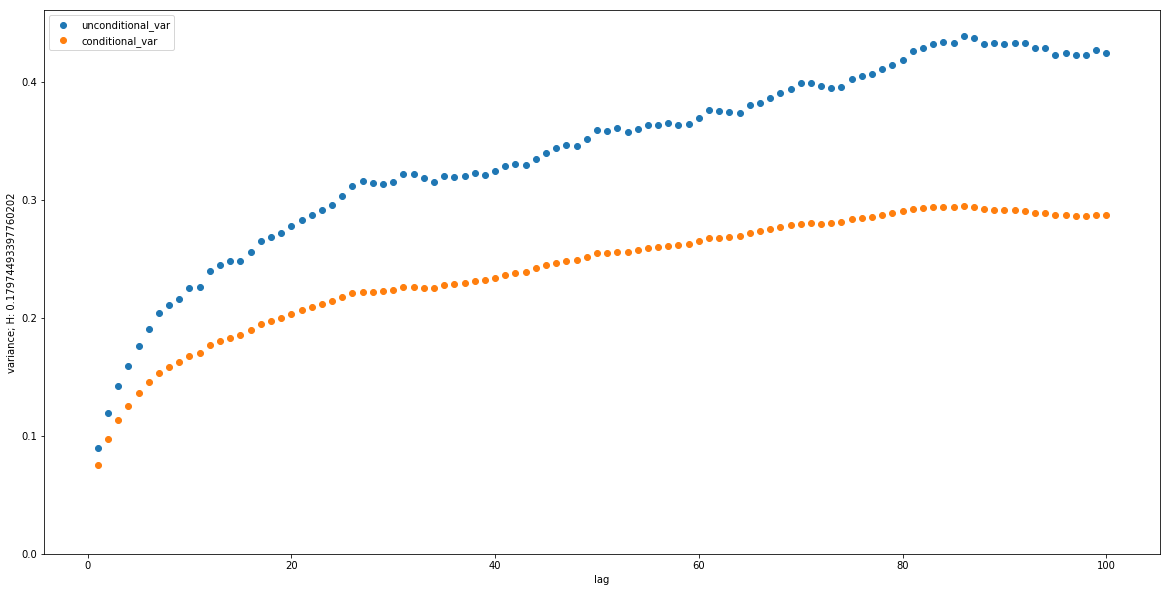

In [10]:
fgraph = forward_graph_rough(RoughVol(),)
plt.figure(figsize=(20,10))
fgraph.plot(np.sqrt(df_rk.query("Symbol == '.SPX'")['rk_th2'].values))

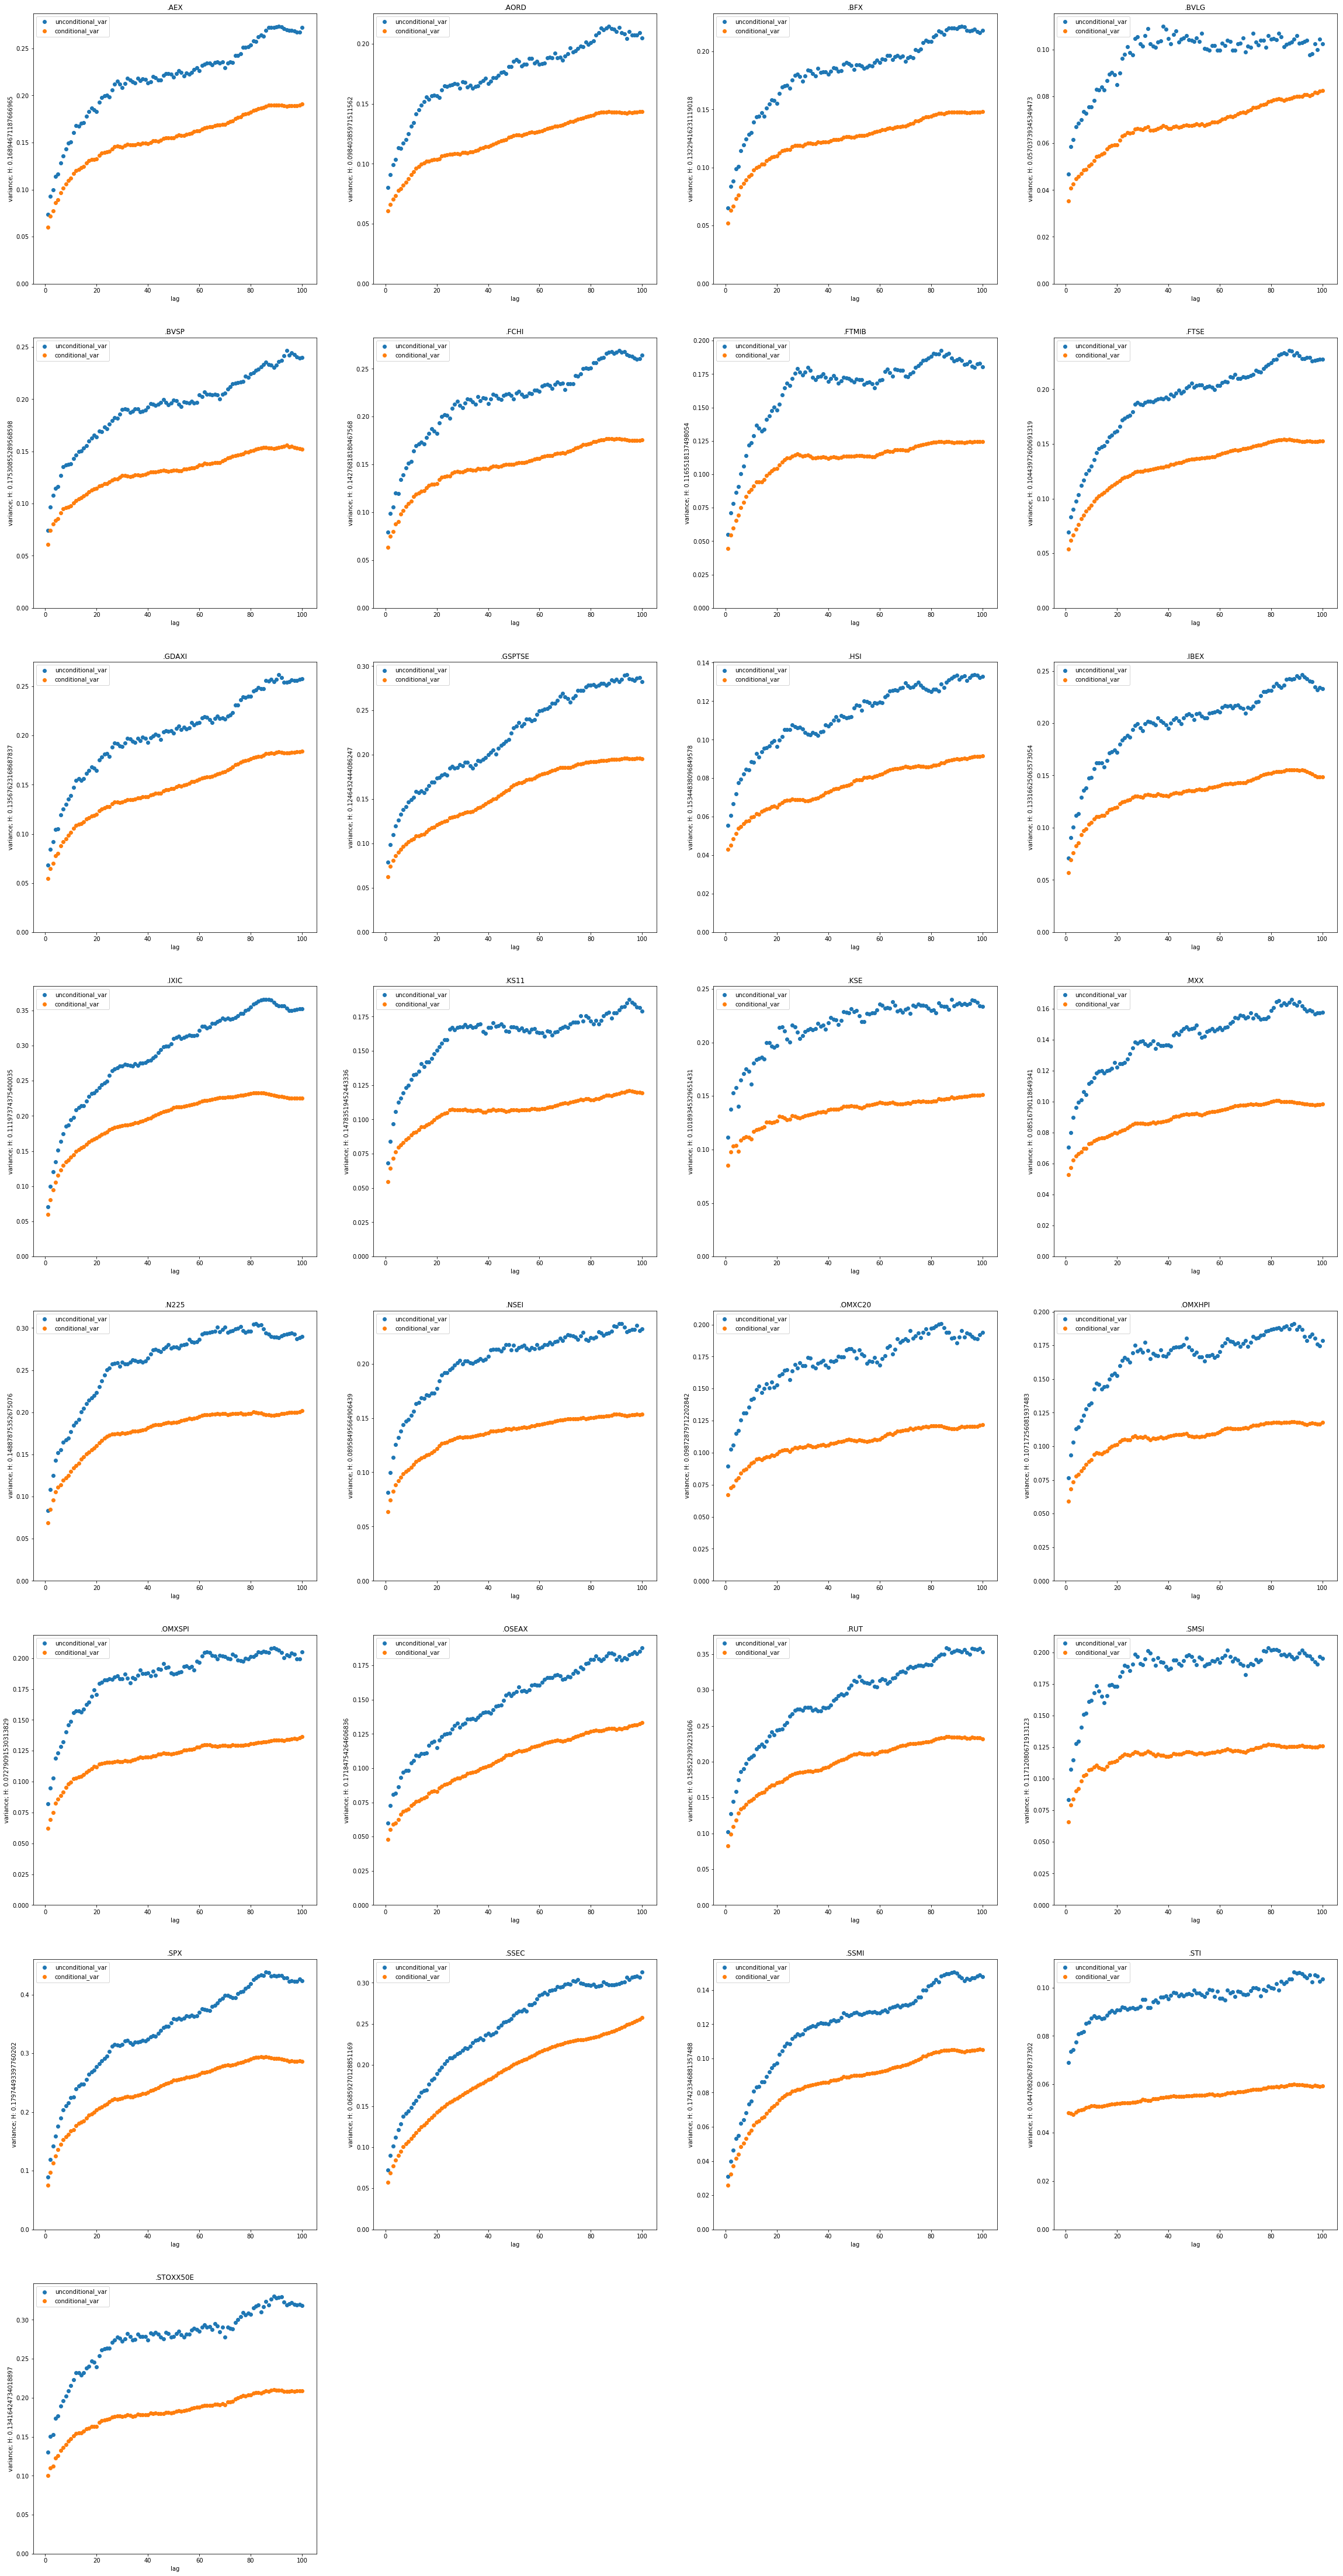

In [11]:
fgraph = forward_graph_rough()
plt.figure(figsize=(40,80))
count=0
for name in tqdm(df_rk.Symbol.unique()):
    tempt_data=df_rk.query("Symbol==@name")['rk_th2'].values
    if np.min(tempt_data)<=0:
        continue
    tempt_data=np.sqrt(df_rk.query("Symbol==@name")['rk_th2'].values)
    
    count+=1
    plt.subplot(8,4,count)
    try:
        fgraph.plot(tempt_data,log=True,verbose =False)
        plt.title(f"{name}")
    except:
        count -= 1
    
    

In [12]:
rmodel = RoughVol()

In [13]:
rmodel

In [14]:
fit_period=200
time_forward=1
data[(len(data)/2-fit_period):(len(data)-time_forward+1)]

NameError: name 'data' is not defined

In [ ]:
data[1:2]

In [ ]:
(len(data)-time_forward+1)

In [ ]:
(len(data)/2-fit_period)

In [15]:
df_rk.query("Symbol == '.SPX'").corr()

,rk_th2
rk_th2,1.0
